# Dust Detection from Remote Sensing Images
In this notebook input images are used from MODIS Terra satellite from NASA. Here one sample .hdf file is used for input.
There is one data folder where the .hdf file is located. That file is downloaded from NASA LAADS DAAC.

##### All the Necessary packages and libraries are loaded

In [8]:
from scipy.signal import cspline2d

import imageio as img
import cv2
from PIL import Image
from skimage import io


import matplotlib.pyplot as plt

from satpy import Scene, MultiScene, available_readers, available_writers, find_files_and_readers
from satpy.readers import modis_l1b, modis_l2
from satpy.writers import get_enhanced_image
from satpy.composites import GenericCompositor

import numpy as np
import pandas as pd
from pyresample import geometry

import os
import warnings

import matplotlib.pyplot as plt
import earthpy as et
import earthpy.plot as ep

from datetime import datetime

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import img_to_array, load_img

import tensorflow as tf
# import statements
import torch
import torch.nn as nn
from torch.utils import data
from torchvision import datasets, transforms, models
import argparse
from tqdm import tqdm
import time
import torchvision

from tensorboardX import SummaryWriter

# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import UnNormalize
from torch.utils.data import Dataset, DataLoader

# from utils import load_checkpoint, save_checkpoint, ensure_dir
# from model import MyModel

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Module 1: Remote Sensing MODIS Data
##### Checking the directory to find the location of data

In [6]:
#####################
# LOADING DATASET
#####################

def content_from_path(path):
    return os.listdir(path)

def generate_data_from_path(path):
    images = []
    dataset_path = content_from_path(path)
    
    for item in dataset_path:
        images.append(("Yes", item))
        
    return images
     
def generate_data_from_folder():
    images = []
    
    for item in dataset_path:
        path = 'nasa' + '/' + item
        if os.path.isdir(path):  
            image = os.listdir(path)
            images.append(("Yes", str(path + '/' + image[0])))
    return images

In [ ]:
#####################
# MAKING DATAFRAME
#####################

images = generate_data_from_path('nasa-calibrated-resize');
dust_df = pd.DataFrame(data=images, columns=["Dust", "image"])
dust_df

In [ ]:
##################################################
# MAKING HORIZONTAL SPLITTED DATASET
##################################################

counter = 0
for item in dust_df['image']:
    
    input_path = "nasa-calibrated-resize/" + item
    if input_path.endswith('DS_Store') or os.path.isdir(input_path):
        continue
    outputPath = "horizontal/"
    
    img = cv2.imread(input_path)
    im = Image.open(input_path)
    x_width, y_height = im.size
    # print(x_width, y_height)
    
    outputFileFormat = "{0}-{1}.jpg"
    baseName = "cropped"
    
    split = 10
    edges = np.linspace(0, x_width, split + 1)
    # print(edges)
    # print(edges[:-1])
    # print(edges[1:])
    for start, end in zip(edges[:-1], edges[1:]):
        box = (start, 0, end, y_height)
        a = im.crop(box)
        x_width, y_height = a.size
        # print(x_width, y_height)
        a.load()
        outputName = os.path.join(outputPath, outputFileFormat.format(baseName, counter + 1))
        counter = counter + 1
        # print(outputName)
        a.save(outputName, "JPEG")
        
horizontal_images = generate_data_from_path('horizontal');
dust_df_horizontal = pd.DataFrame(data=horizontal_images, columns=["Dust", "image"])
dust_df_horizontal

In [ ]:
for item in dust_df_horizontal['image']:
    
    input_path = "horizontal/" + item
    if input_path.endswith('DS_Store') or os.path.isdir(input_path):
        continue
    
    img = cv2.imread(input_path)
    im = Image.open(input_path)
    # im.show()
    x_width, y_height = im.size
    print(x_width, y_height)
    # print(img.shape)
    # print(input_path)
    if x_width != 128:
        print(input_path)
        os.remove(input_path)
    # break

In [ ]:
##################################################
# MAKING VERTICAL SPLITTED DATASET
##################################################

counter = 0
for item in dust_df_horizontal['image']:
    
    input_path = "horizontal/" + item
    if input_path.endswith('DS_Store') or os.path.isdir(input_path):
        continue
    outputPath = "horizontal/final"
    
    img = cv2.imread(input_path)
    im = Image.open(input_path)
    x_width, y_height = im.size
    # print(x_width, y_height)
    
    outputFileFormat = "{0}-{1}.jpg"
    baseName = "cropped"
    
    split = 15
    edges = np.linspace(0, y_height, split + 1)
    # print(edges)
    # print(edges[:-1])
    # print(edges[1:])
    for start, end in zip(edges[:-1], edges[1:]):
        box = (0, start, x_width, end)
        a = im.crop(box)
        a.load()
        outputName = os.path.join(outputPath, outputFileFormat.format(baseName, counter + 1))
        counter = counter + 1
        # print(outputName)
        a.save(outputName, "JPEG")
        
final_images = generate_data_from_path('horizontal/final');
dust_df_final = pd.DataFrame(data=final_images, columns=["Dust", "image"])
dust_df_final

In [ ]:
for item in dust_df_final['image']:
    
    input_path = "horizontal/final/" + item
    if input_path.endswith('DS_Store') or os.path.isdir(input_path):
        continue
    count = 1
    img = cv2.imread(input_path)
    im = Image.open(input_path)
    # im.show()
    x_width, y_height = im.size
    print(x_width, y_height)
    # print(item.index)
    if y_height != 128:
        print(img.shape)
        os.remove(input_path)
    # break

In [7]:
##########################################
# MAKING FINAL DATAFRAME
##########################################

images = generate_data_from_path('horizontal/final/');
dust_df_final_calibrated = pd.DataFrame(data=images, columns=["Dust", "image"])
dust_df_final_calibrated

,Dust,image
0,Yes,cropped-15032.jpg
1,Yes,cropped-8525.jpg
2,Yes,cropped-7616.jpg
3,Yes,cropped-6508.jpg
4,Yes,cropped-995.jpg
...,...,...
19136,Yes,cropped-9622.jpg
19137,Yes,cropped-6511.jpg
19138,Yes,cropped-14335.jpg
19139,Yes,cropped-754.jpg


In [ ]:
for item in dust_df_final_calibrated['image']:
    
    input_path = "horizontal/final/" + item
    if input_path.endswith('DS_Store') or os.path.isdir(input_path):
        continue
    count = 1
    img = cv2.imread(input_path)
    im = Image.open(input_path)
    # im.show()
    x_width, y_height = im.size
    print(x_width, y_height)

In [9]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 15
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

In [10]:
class DustDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        # print(img_path)
        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [11]:
##########################
### FINAL DUST DATASET
##########################

# resize_transform = torchvision.transforms.Compose(
#     [torchvision.transforms.Resize((32, 32)),
#      torchvision.transforms.ToTensor(),
#      torchvision.transforms.Normalize((0.5,), (0.5,))])

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

test_transforms = torchvision.transforms.Compose([       
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load Data
dataset = DustDataset(
    csv_file="dataset.csv",
    root_dir="horizontal/dataset/",
    transform=train_transforms,
)

train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [256, 30, 33])
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE, shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0])


In [12]:
class AlexNetDust(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        return logits

/opt/anaconda3/envs/rafi/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 001/015 | Batch 0000/0001 | Loss: 0.6909
Epoch: 001/015 | Train: 81.25% | Validation: 73.33%
Time elapsed: 0.14 min
Epoch: 002/015 | Batch 0000/0001 | Loss: 0.6627
Epoch: 002/015 | Train: 81.25% | Validation: 73.33%
Time elapsed: 0.28 min
Epoch: 003/015 | Batch 0000/0001 | Loss: 0.6168
Epoch: 003/015 | Train: 81.25% | Validation: 73.33%
Time elapsed: 0.41 min
Epoch: 004/015 | Batch 0000/0001 | Loss: 0.5646
Epoch: 004/015 | Train: 81.25% | Validation: 73.33%
Time elapsed: 0.54 min
Epoch: 005/015 | Batch 0000/0001 | Loss: 0.5160
Epoch: 005/015 | Train: 81.25% | Validation: 73.33%
Time elapsed: 0.67 min
Epoch: 006/015 | Batch 0000/0001 | Loss: 0.4764
Epoch: 006/015 | Train: 81.25% | Validation: 73.33%
Time elapsed: 0.80 min
Epoch: 007/015 | Batch 0000/0001 | Loss: 0.4521
Epoch: 007/015 | Train: 81.25% | Validation: 73.33%
Time elapsed: 0.93 min
Epoch: 008/015 | Batch 0000/0001 | Loss: 0.4728
Epoch: 008/015 | Train: 81.25% | Validation: 73.33%
Time elapsed: 1.06 min
Epoch: 009/015 |

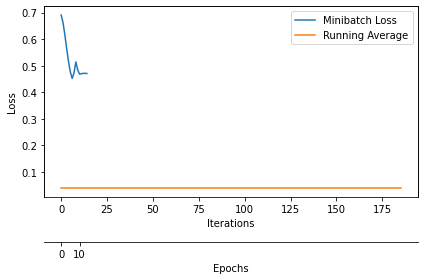

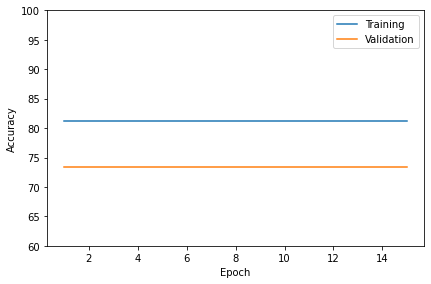

In [13]:
model = AlexNetDust(num_classes=2)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

##### Changing the folder to data to get access of the .hdf file
This file is downloaded before from NASA LAADS DAAC. Changing the directory should be executed only once otherwise it will show error because it has already changed the directory.


In [ ]:
# Set working directory to data to get access of the file
# os.chdir(os.path.join(os.getcwd(), 'data'))

# Accessing file for processing
filename = os.path.join("MOD021KM.A2021092.0020.006.2021092134055.hdf")
filenames = [filename]

##### Loading data to scene object from SatPy. 
SatPy is used here for processing remote sensing images
Printing available dataset names which is required for listing the bands
Here total 36 bands information are available

In [ ]:
# MODIS scene object using the file retrieved from data folder
modis_scene = Scene(reader='modis_l1b', filenames=filenames)
modis_scene.available_dataset_names()
# modis_scene.unload

##### Method: Band Details and Plotting
This is the custom method which takes band no and color map as parameter and shows all the necessary information about that particular band. The second method plot_band() takes the band no as parameter and plot the band.

In [ ]:
def band_details(band_no, cmap):
    
    print("Band no: ", band_no)
    print("Platform name: ", modis_scene[band_no].attrs['platform_name'])
    print("Dimension: ", modis_scene[band_no].dims)
    print("No of dimension: ", modis_scene[band_no].ndim)
    print("Wavelength: ", modis_scene[band_no].wavelength)
    print("Calibration: ", modis_scene[band_no].calibration)
    print("Maximum value: ", modis_scene[band_no].max().values)
    
    modis_scene[band_no].plot.imshow(cmap=cmap)
    plt.title("Band-{}".format(band_no))

def plot_band(band_no):

    plt.figure()
    modis_scene.load([band_no])
    band_details(band_no, 'cividis')
    modis_scene[band_no]

In [ ]:
band_no = '3'
plot_band(band_no)

### Data Extraction
Image data is extrcted from the metadata of MODIS hdf file

In [ ]:
data = modis_scene[band_no]
data

### Resizing Image
The dimension of input image is too high so the reduced dimension of image is used by resizing it to (128, 128) where original image dimension was (2030, 1354). Finally image value is normalized by dividing by 255. Image is first converted to matrix and then again to numpy array to match the dimension.

In [ ]:
iteration = 100

image = resize(img_to_array(modis_scene[band_no]), (128, 128),  mode = 'constant', preserve_range = True)
image = image/255.0
image.shape
image = np.matrix(image)
image = np.array(image)
image


In [ ]:
# Plotting the image after resizing
plt.figure()
plt.imshow(image, cmap = 'viridis')
plt.title('Band - ' + band_no)

In [ ]:
modis_scene.unload